# This notebook cleans the listings.csv file

In [2]:
import numpy as np 
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [3]:
data = pd.read_csv('reviews.csv')
data.head()
data.fillna('none', inplace=True)

In [8]:
len(data)

243183

In [9]:
listings = pd.read_csv('listings.csv')
listings['listing_id'] = listings['id']

listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,listing_id
0,44077,https://www.airbnb.com/rooms/44077,20220911231053,2022-09-12,city scrape,cosy comfortable Irish cottage twin,Our house was built in 1937 when there was ple...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,...,4.66,4.82,NaN,f,2,0,2,0,1.85,44077
1,85156,https://www.airbnb.com/rooms/85156,20220911231053,2022-09-12,city scrape,Cosy Comfortable Irish Cottage 1 Double Bed,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",https://a0.muscache.com/pictures/1749253/9ed2a...,193005,...,4.64,4.78,NaN,f,2,0,2,0,1.53,85156
2,159889,https://www.airbnb.com/rooms/159889,20220911231053,2022-09-12,city scrape,Friendly Single Room,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,https://a0.muscache.com/pictures/3031697/a8259...,766611,...,4.63,4.74,NaN,f,3,0,3,0,2.78,159889
3,162809,https://www.airbnb.com/rooms/162809,20220911231053,2022-09-11,city scrape,5.5 miles south of Dublin City :^),A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",https://a0.muscache.com/pictures/86694529/c07b...,777681,...,4.77,4.85,NaN,f,2,0,2,0,3.68,162809
4,165828,https://www.airbnb.com/rooms/165828,20220911231053,2022-09-11,city scrape,Pádraig Pearse apt. Kilmainham,"Don't just visit Dublin, experience Dublin in ...","Enjoy a walk along the grand canal, or just ob...",https://a0.muscache.com/pictures/34311419/b3f6...,790601,...,4.34,4.55,NaN,t,5,5,0,0,0.48,165828


In [10]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7566 entries, 0 to 7565
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7566 non-null   int64  
 1   listing_url                                   7566 non-null   object 
 2   scrape_id                                     7566 non-null   int64  
 3   last_scraped                                  7566 non-null   object 
 4   source                                        7566 non-null   object 
 5   name                                          7566 non-null   object 
 6   description                                   7411 non-null   object 
 7   neighborhood_overview                         4194 non-null   object 
 8   picture_url                                   7566 non-null   object 
 9   host_id                                       7566 non-null   i

In [28]:
# data insights
print('mean number_of_reviews: ', listings['number_of_reviews'].mean())
print('mean availability_365: ', listings['availability_365'].mean())

print('median number_of_reviews: ', listings['number_of_reviews'].median())
print('median availability_365: ', listings['availability_365'].median())

mean number_of_reviews:  32.141554321966694
mean availability_365:  64.79962992334126
median number_of_reviews:  7.0
median availability_365:  0.0


In [21]:
data.describe()

,listing_id,id,reviewer_id
count,2.431830e+05,2.431830e+05,2.431830e+05
mean,2.089457e+16,1.515855e+17,1.221460e+08
std,1.118344e+17,2.630469e+17,1.130217e+08
min,4.407700e+04,2.037030e+05,1.260000e+02
25%,1.098780e+07,2.381510e+08,3.326969e+07
50%,1.861423e+07,4.461919e+08,8.688698e+07
75%,2.768005e+07,4.084579e+17,1.796179e+08
max,7.100541e+17,7.136614e+17,4.786623e+08


In [22]:
data.isnull().mean()


listing_id       0.0
id               0.0
date             0.0
reviewer_id      0.0
reviewer_name    0.0
comments         0.0
dtype: float64

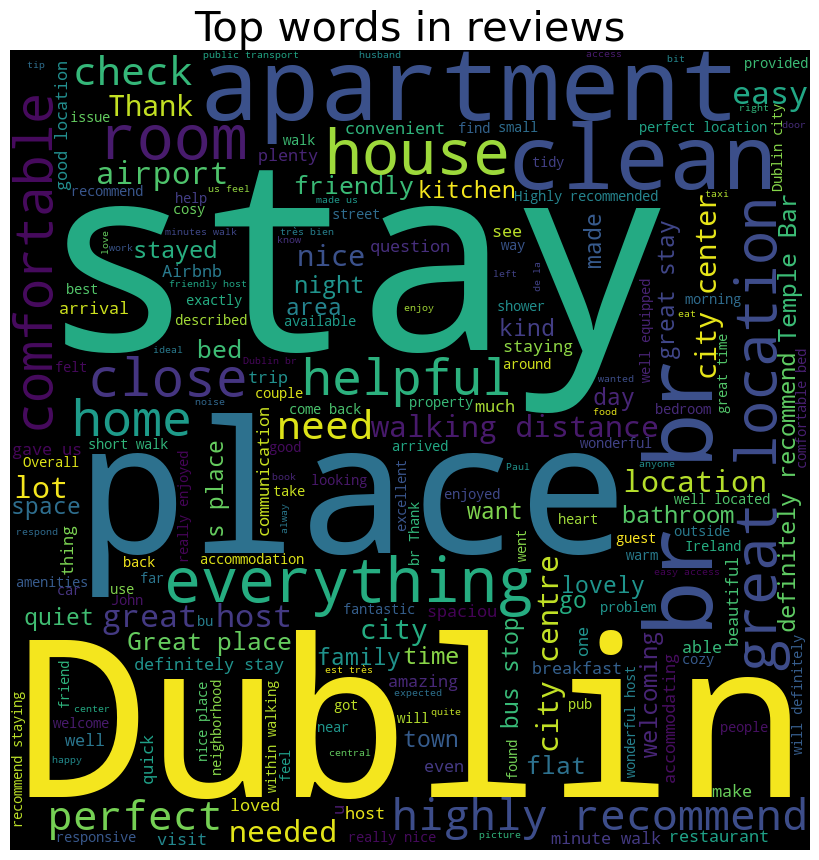

In [23]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(map(str, data.values)))                      
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()
wordCloud_generator(data['comments'], title="Top words in reviews")

In [45]:
listings = listings.merge(temp, on='listing_id', how='left')

In [46]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,44077,https://www.airbnb.com/rooms/44077,20220911231053,2022-09-12,city scrape,cosy comfortable Irish cottage twin,Our house was built in 1937 when there was ple...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,...,0.006926,0.002212,0.005132,0.001908,0.034302,0.006679,0.001293,0.036828,0.002666,0.004258
1,85156,https://www.airbnb.com/rooms/85156,20220911231053,2022-09-12,city scrape,Cosy Comfortable Irish Cottage 1 Double Bed,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",https://a0.muscache.com/pictures/1749253/9ed2a...,193005,...,0.009777,0.000000,0.004088,0.002559,0.031895,0.002915,0.000000,0.029999,0.001756,0.007132
2,159889,https://www.airbnb.com/rooms/159889,20220911231053,2022-09-12,city scrape,Friendly Single Room,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,https://a0.muscache.com/pictures/3031697/a8259...,766611,...,0.000000,0.003977,0.005308,0.001376,0.018446,0.004405,0.000657,0.024806,0.000802,0.001876
3,162809,https://www.airbnb.com/rooms/162809,20220911231053,2022-09-11,city scrape,5.5 miles south of Dublin City :^),A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",https://a0.muscache.com/pictures/86694529/c07b...,777681,...,0.005324,0.004071,0.001262,0.004644,0.013077,0.003290,0.003519,0.023482,0.002346,0.001190
4,165828,https://www.airbnb.com/rooms/165828,20220911231053,2022-09-11,city scrape,Pádraig Pearse apt. Kilmainham,"Don't just visit Dublin, experience Dublin in ...","Enjoy a walk along the grand canal, or just ob...",https://a0.muscache.com/pictures/34311419/b3f6...,790601,...,0.022646,0.000000,0.005209,0.003363,0.019759,0.009355,0.007937,0.044699,0.002396,0.004496


In [47]:
# do some analysis to reach here later
#intuitively listing
column_removal = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id',
                          'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                          'neighbourhood_group_cleansed', 'latitude', 'longitude', 
                          'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
                          'calendar_last_scraped', 'first_review', 'last_review']


In [48]:
#drop unimportant columns
listings = listings.drop(columns=column_removal)

In [49]:
listings.describe()

,id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
count,7.566000e+03,7566.000000,7566.000000,7566.000000,0.0,7361.000000,7472.000000,7566.000000,7566.000000,7566.000000,...,6209.000000,6209.000000,6209.000000,6209.000000,6209.000000,6209.000000,6209.000000,6209.000000,6209.000000,6209.000000
mean,1.265543e+17,24.575601,39.837959,3.006080,NaN,1.523978,1.832575,6.253899,528.207507,2.956913,...,0.002429,0.002192,0.006875,0.002748,0.013412,0.006937,0.002290,0.028858,0.001774,0.002007
std,2.581749e+17,202.623363,340.458134,1.888488,NaN,0.919004,1.354338,28.165241,517.363963,6.021178,...,0.014300,0.011951,0.018476,0.013508,0.029140,0.022467,0.015976,0.033950,0.011310,0.008732
min,4.407700e+04,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.742072e+07,1.000000,1.000000,2.000000,NaN,1.000000,1.000000,1.000000,15.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.798028e+07,1.000000,2.000000,2.000000,NaN,1.000000,1.000000,2.000000,365.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025092,0.000000,0.000000
75%,5.034204e+07,3.000000,4.000000,4.000000,NaN,2.000000,2.000000,4.000000,1125.000000,3.000000,...,0.000000,0.000000,0.008056,0.000000,0.017886,0.006660,0.000000,0.039682,0.000000,0.000000
max,7.130342e+17,2157.000000,12017.000000,16.000000,NaN,13.000000,18.000000,1125.000000,1125.000000,30.000000,...,0.487472,0.493837,0.439432,0.427184,0.739880,0.758555,0.849745,0.484388,0.377491,0.218442


In [50]:
listings.head()

,id,name,description,neighborhood_overview,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,44077,cosy comfortable Irish cottage twin,Our house was built in 1937 when there was ple...,I like our neighbourhood as there is no shorta...,2010-08-06,"Dublin, Ireland",within an hour,100%,99%,t,...,0.006926,0.002212,0.005132,0.001908,0.034302,0.006679,0.001293,0.036828,0.002666,0.004258
1,85156,Cosy Comfortable Irish Cottage 1 Double Bed,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",2010-08-06,"Dublin, Ireland",within an hour,100%,99%,t,...,0.009777,0.000000,0.004088,0.002559,0.031895,0.002915,0.000000,0.029999,0.001756,0.007132
2,159889,Friendly Single Room,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,2011-07-01,"Dublin, Ireland",within an hour,100%,95%,f,...,0.000000,0.003977,0.005308,0.001376,0.018446,0.004405,0.000657,0.024806,0.000802,0.001876
3,162809,5.5 miles south of Dublin City :^),A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",2011-07-04,"Dublin, Ireland",within an hour,92%,87%,t,...,0.005324,0.004071,0.001262,0.004644,0.013077,0.003290,0.003519,0.023482,0.002346,0.001190
4,165828,Pádraig Pearse apt. Kilmainham,"Don't just visit Dublin, experience Dublin in ...","Enjoy a walk along the grand canal, or just ob...",2011-07-07,Ireland,within an hour,100%,91%,f,...,0.022646,0.000000,0.005209,0.003363,0.019759,0.009355,0.007937,0.044699,0.002396,0.004496


In [51]:
list(listings.columns)

['id',
 'name',
 'description',
 'neighborhood_overview',
 'host_since',
 'host_location',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host

In [52]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhinawtiwari/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [53]:
# sentiments for name and description
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [55]:
res = {}
for i, row in tqdm(listings.iterrows(), total=len(listings)):
    name = row['name']
    id = row['id']
    res[id] = sia.polarity_scores(name)

  0%|          | 0/7566 [00:00<?, ?it/s]

In [56]:
vaders_on_name = pd.DataFrame(res).T
vaders_on_name

,neg,neu,pos,compound
44077,0.0,0.548,0.452,0.5106
85156,0.0,0.602,0.398,0.5106
159889,0.0,0.385,0.615,0.4939
162809,0.0,0.659,0.341,0.4767
165828,0.0,1.000,0.000,0.0000
...,...,...,...,...
712909401324393615,0.0,0.602,0.398,0.5106
712914322433199115,0.0,0.388,0.612,0.7430
712914393022526732,0.0,0.236,0.764,0.8658
712966369602352444,0.0,1.000,0.000,0.0000


In [57]:
vaders_on_name = pd.DataFrame(res).T
vaders_on_name = vaders_on_name.reset_index().rename(columns={'index': 'id'})
vaders_on_name = vaders_on_name.merge(listings, how='left')

In [71]:
vaders_on_name.head()

,id,neg,neu,pos,compound,name,description,neighborhood_overview,host_since,host_location,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,44077,0.0,0.548,0.452,0.5106,cosy comfortable Irish cottage twin,Our house was built in 1937 when there was ple...,I like our neighbourhood as there is no shorta...,2010-08-06,"Dublin, Ireland",...,0.006926,0.002212,0.005132,0.001908,0.034302,0.006679,0.001293,0.036828,0.002666,0.004258
1,85156,0.0,0.602,0.398,0.5106,Cosy Comfortable Irish Cottage 1 Double Bed,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",2010-08-06,"Dublin, Ireland",...,0.009777,0.000000,0.004088,0.002559,0.031895,0.002915,0.000000,0.029999,0.001756,0.007132
2,159889,0.0,0.385,0.615,0.4939,Friendly Single Room,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,2011-07-01,"Dublin, Ireland",...,0.000000,0.003977,0.005308,0.001376,0.018446,0.004405,0.000657,0.024806,0.000802,0.001876
3,162809,0.0,0.659,0.341,0.4767,5.5 miles south of Dublin City :^),A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",2011-07-04,"Dublin, Ireland",...,0.005324,0.004071,0.001262,0.004644,0.013077,0.003290,0.003519,0.023482,0.002346,0.001190
4,165828,0.0,1.000,0.000,0.0000,Pádraig Pearse apt. Kilmainham,"Don't just visit Dublin, experience Dublin in ...","Enjoy a walk along the grand canal, or just ob...",2011-07-07,Ireland,...,0.022646,0.000000,0.005209,0.003363,0.019759,0.009355,0.007937,0.044699,0.002396,0.004496


In [58]:
# drop name column
vaders_on_name = vaders_on_name.drop(columns=['name'])

In [59]:
vaders_on_name = vaders_on_name.rename(columns={"neg": "name_neg", "neu": "name_neu", "pos": "name_pos", "compound": "name_compound"})

In [60]:
vaders_on_name.head()

,id,name_neg,name_neu,name_pos,name_compound,description,neighborhood_overview,host_since,host_location,host_response_time,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,44077,0.0,0.548,0.452,0.5106,Our house was built in 1937 when there was ple...,I like our neighbourhood as there is no shorta...,2010-08-06,"Dublin, Ireland",within an hour,...,0.006926,0.002212,0.005132,0.001908,0.034302,0.006679,0.001293,0.036828,0.002666,0.004258
1,85156,0.0,0.602,0.398,0.5106,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",2010-08-06,"Dublin, Ireland",within an hour,...,0.009777,0.000000,0.004088,0.002559,0.031895,0.002915,0.000000,0.029999,0.001756,0.007132
2,159889,0.0,0.385,0.615,0.4939,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,2011-07-01,"Dublin, Ireland",within an hour,...,0.000000,0.003977,0.005308,0.001376,0.018446,0.004405,0.000657,0.024806,0.000802,0.001876
3,162809,0.0,0.659,0.341,0.4767,A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",2011-07-04,"Dublin, Ireland",within an hour,...,0.005324,0.004071,0.001262,0.004644,0.013077,0.003290,0.003519,0.023482,0.002346,0.001190
4,165828,0.0,1.000,0.000,0.0000,"Don't just visit Dublin, experience Dublin in ...","Enjoy a walk along the grand canal, or just ob...",2011-07-07,Ireland,within an hour,...,0.022646,0.000000,0.005209,0.003363,0.019759,0.009355,0.007937,0.044699,0.002396,0.004496


In [64]:
listings = vaders_on_name.copy()
listings.fillna('none', inplace=True) # avoid float value for nan in description column

In [66]:
# find sentiments of description and drop description column
res = {}
for i, row in tqdm(listings.iterrows(), total=len(listings)):
    description = row['description']
    id = row['id']
    res[id] = sia.polarity_scores(description)

  0%|          | 0/7566 [00:00<?, ?it/s]

In [67]:
vaders_on_desc = pd.DataFrame(res).T
vaders_on_desc.head()

,neg,neu,pos,compound
44077,0.000,0.853,0.147,0.9808
85156,0.009,0.893,0.098,0.9544
159889,0.000,0.899,0.101,0.9524
162809,0.020,0.784,0.196,0.9844
165828,0.000,0.855,0.145,0.9702


In [68]:
vaders_on_desc = pd.DataFrame(res).T
vaders_on_desc = vaders_on_desc.reset_index().rename(columns={'index': 'id'})
vaders_on_desc = vaders_on_desc.merge(listings, how='left')

In [69]:
vaders_on_desc.head()

,id,neg,neu,pos,compound,name_neg,name_neu,name_pos,name_compound,description,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,44077,0.000,0.853,0.147,0.9808,0.0,0.548,0.452,0.5106,Our house was built in 1937 when there was ple...,...,0.006926,0.002212,0.005132,0.001908,0.034302,0.006679,0.001293,0.036828,0.002666,0.004258
1,85156,0.009,0.893,0.098,0.9544,0.0,0.602,0.398,0.5106,Our Cottage is a charming light filled cottage...,...,0.009777,0.0,0.004088,0.002559,0.031895,0.002915,0.0,0.029999,0.001756,0.007132
2,159889,0.000,0.899,0.101,0.9524,0.0,0.385,0.615,0.4939,Washing can be done at a cost of €5 per load....,...,0.0,0.003977,0.005308,0.001376,0.018446,0.004405,0.000657,0.024806,0.000802,0.001876
3,162809,0.020,0.784,0.196,0.9844,0.0,0.659,0.341,0.4767,A nice place to relax after the bustle of the ...,...,0.005324,0.004071,0.001262,0.004644,0.013077,0.00329,0.003519,0.023482,0.002346,0.00119
4,165828,0.000,0.855,0.145,0.9702,0.0,1.000,0.000,0.0000,"Don't just visit Dublin, experience Dublin in ...",...,0.022646,0.0,0.005209,0.003363,0.019759,0.009355,0.007937,0.044699,0.002396,0.004496


In [70]:
# rename and drop for description
vaders_on_desc = vaders_on_desc.drop(columns=['description'])
vaders_on_desc = vaders_on_desc.rename(columns={"neg": "desc_neg", "neu": "desc_neu", "pos": "desc_pos", "compound": "desc_compound"})

In [71]:
vaders_on_desc.head()

,id,desc_neg,desc_neu,desc_pos,desc_compound,name_neg,name_neu,name_pos,name_compound,neighborhood_overview,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,44077,0.000,0.853,0.147,0.9808,0.0,0.548,0.452,0.5106,I like our neighbourhood as there is no shorta...,...,0.006926,0.002212,0.005132,0.001908,0.034302,0.006679,0.001293,0.036828,0.002666,0.004258
1,85156,0.009,0.893,0.098,0.9544,0.0,0.602,0.398,0.5106,"I love Dundrum and its surrounding areas ,<br ...",...,0.009777,0.0,0.004088,0.002559,0.031895,0.002915,0.0,0.029999,0.001756,0.007132
2,159889,0.000,0.899,0.101,0.9524,0.0,0.385,0.615,0.4939,Plenty of buses into the city and the area is ...,...,0.0,0.003977,0.005308,0.001376,0.018446,0.004405,0.000657,0.024806,0.000802,0.001876
3,162809,0.020,0.784,0.196,0.9844,0.0,0.659,0.341,0.4767,"Close to the sea, hill walks and the city - vi...",...,0.005324,0.004071,0.001262,0.004644,0.013077,0.00329,0.003519,0.023482,0.002346,0.00119
4,165828,0.000,0.855,0.145,0.9702,0.0,1.000,0.000,0.0000,"Enjoy a walk along the grand canal, or just ob...",...,0.022646,0.0,0.005209,0.003363,0.019759,0.009355,0.007937,0.044699,0.002396,0.004496


In [72]:
# repeat sentiment analysis for neighborhood_overview column
listings = vaders_on_desc.copy()

# find sentiments of description and drop description column
res = {}
for i, row in tqdm(listings.iterrows(), total=len(listings)):
    neighborhood_overview = row['neighborhood_overview']
    id = row['id']
    res[id] = sia.polarity_scores(neighborhood_overview)

res_vader = pd.DataFrame(res).T
res_vader = res_vader.reset_index().rename(columns={'index': 'id'})
res_vader = res_vader.merge(listings, how='left')

# rename and drop for description
res_vader = res_vader.drop(columns=['neighborhood_overview'])
res_vader = res_vader.rename(columns={"neg": "no_neg", "neu": "no_neu", "pos": "no_pos", "compound": "no_compound"})

res_vader.head()

  0%|          | 0/7566 [00:00<?, ?it/s]

,id,no_neg,no_neu,no_pos,no_compound,desc_neg,desc_neu,desc_pos,desc_compound,name_neg,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,44077,0.057,0.820,0.123,0.7003,0.000,0.853,0.147,0.9808,0.0,...,0.006926,0.002212,0.005132,0.001908,0.034302,0.006679,0.001293,0.036828,0.002666,0.004258
1,85156,0.011,0.778,0.211,0.9906,0.009,0.893,0.098,0.9544,0.0,...,0.009777,0.0,0.004088,0.002559,0.031895,0.002915,0.0,0.029999,0.001756,0.007132
2,159889,0.000,0.784,0.216,0.5106,0.000,0.899,0.101,0.9524,0.0,...,0.0,0.003977,0.005308,0.001376,0.018446,0.004405,0.000657,0.024806,0.000802,0.001876
3,162809,0.000,0.873,0.127,0.4939,0.020,0.784,0.196,0.9844,0.0,...,0.005324,0.004071,0.001262,0.004644,0.013077,0.00329,0.003519,0.023482,0.002346,0.00119
4,165828,0.044,0.738,0.218,0.9274,0.000,0.855,0.145,0.9702,0.0,...,0.022646,0.0,0.005209,0.003363,0.019759,0.009355,0.007937,0.044699,0.002396,0.004496


In [73]:
# after sentiment analysis on comments and merge with listings, sentiments on name, description and neighbourhood overview
# saving the state
res_vader.to_csv("dataset.csv")

In [74]:
listings = res_vader.copy()
listings.host_since.head()

0    2010-08-06
1    2010-08-06
2    2011-07-01
3    2011-07-04
4    2011-07-07
Name: host_since, dtype: object

In [75]:
listings['host_since'] = pd.to_datetime(listings['host_since'], format = '%Y-%m-%d', errors = 'coerce')

In [76]:
assert listings.host_since.isnull().sum() == 0, 'missing host since dates'

In [77]:
listings.host_since.head()

0   2010-08-06
1   2010-08-06
2   2011-07-01
3   2011-07-04
4   2011-07-07
Name: host_since, dtype: datetime64[ns]

In [78]:
# one hot encoding for top 10/20 of host_location
len(listings['host_location'].unique())

442

In [80]:
# find top most frequent host location
listings.host_location.value_counts().sort_values(ascending=False).head(20)

Dublin, Ireland            4295
none                       1334
County Dublin, Ireland      211
Ireland                     156
London, United Kingdom      114
Swords, Ireland              65
Delhi, India                 49
County Wicklow, Ireland      43
Firhouse, Ireland            42
Paris, France                33
Malahide, Ireland            31
Bray, Ireland                30
Balbriggan, Ireland          24
Leixlip, Ireland             21
Skerries, Ireland            21
Clontarf, Ireland            19
Belfast, United Kingdom      18
Castleknock, Ireland         18
Ballsbridge, Ireland         18
Blackrock, Ireland           18
Name: host_location, dtype: int64

In [83]:
# make a list of top 20 host locations
top_20_host_locations = [x for x in listings.host_location.value_counts().sort_values(ascending=False).head(20).index]
top_20_host_locations

['Dublin, Ireland',
 'none',
 'County Dublin, Ireland',
 'Ireland',
 'London, United Kingdom',
 'Swords, Ireland',
 'Delhi, India',
 'County Wicklow, Ireland',
 'Firhouse, Ireland',
 'Paris, France',
 'Malahide, Ireland',
 'Bray, Ireland',
 'Balbriggan, Ireland',
 'Leixlip, Ireland',
 'Skerries, Ireland',
 'Clontarf, Ireland',
 'Belfast, United Kingdom',
 'Castleknock, Ireland',
 'Ballsbridge, Ireland',
 'Blackrock, Ireland']

In [84]:
for location in top_20_host_locations:
    listings[location] = np.where(listings['host_location']==location, 1, 0)

In [85]:
listings[['host_location']+top_20_host_locations].head(40)

,host_location,"Dublin, Ireland",none,"County Dublin, Ireland",Ireland,"London, United Kingdom","Swords, Ireland","Delhi, India","County Wicklow, Ireland","Firhouse, Ireland",...,"Malahide, Ireland","Bray, Ireland","Balbriggan, Ireland","Leixlip, Ireland","Skerries, Ireland","Clontarf, Ireland","Belfast, United Kingdom","Castleknock, Ireland","Ballsbridge, Ireland","Blackrock, Ireland"
0,"Dublin, Ireland",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Dublin, Ireland",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Dublin, Ireland",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Dublin, Ireland",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ireland,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Ireland,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Dublin, Ireland",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Dublin, Ireland",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Dublin, Ireland",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Lucan, Ireland",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
listings.to_csv('abc.csv')

In [89]:
# drop columns
listings = listings.drop(columns=['host_location', 'none'])

In [92]:
# one hot encoding host_response_time
one_hot = pd.get_dummies(listings['host_response_time'])
# Drop column B as it is now encoded
listings = listings.drop('host_response_time',axis = 1)
# Join the encoded df
listings = listings.join(one_hot)

In [105]:
def one_hot_mf(df, column, top):
    print("unique values in the column: ", len(df[column].unique()))
    print(df[column].value_counts().sort_values(ascending=False).head(top))
    top_top_columns = [x for x in df[column].value_counts().sort_values(ascending=False).head(top).index]
    for label in top_top_columns:
        df[label] = np.where(df[column]==label, 1, 0)
    df = df.drop(columns=[column])
    return df

In [222]:
listings = one_hot_mf(listings, 'room_type', 20)

unique values in the column:  4
Entire home/apt    3786
Private room       3563
Shared room         175
Hotel room           42
Name: room_type, dtype: int64


/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/171187283.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[column]==label, 1, 0)
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/171187283.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[column]==label, 1, 0)
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/171187283.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

In [220]:
listings = one_hot_mf(listings, 'property_type', 20)

unique values in the column:  63
Entire rental unit                   1518
Private room in home                 1457
Private room in rental unit          1161
Entire home                          1080
Entire condo                          551
Private room in condo                 341
Private room in townhouse             256
Entire townhouse                      248
Private room in bed and breakfast     106
Entire serviced apartment              91
Shared room in rental unit             86
Entire cottage                         57
Shared room in home                    55
Entire guest suite                     54
Entire guesthouse                      47
Room in hotel                          39
Private room in bungalow               38
Entire loft                            34
Room in boutique hotel                 33
Entire bungalow                        32
Name: property_type, dtype: int64


/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/171187283.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[column]==label, 1, 0)
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/171187283.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = np.where(df[column]==label, 1, 0)
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/171187283.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

In [106]:
# perform one hot encoding for host_neighbourhood
listings = one_hot_mf(listings, 'host_neighbourhood', 20)

unique values in the column:  357
none                                   2332
The Liberties                           238
North City Central/O'Connell Street     230
Docklands                               215
Phibsborough                            212
Temple Bar                              179
Ballsbridge                             166
Ranelagh and Rathmines                  139
Smithfield                              129
Drumcondra                              128
Stoneybatter/Arbour Hill                116
Georgian Quarter                        115
Old City                                112
Trinity College                         105
Portobello                              100
Northside                                91
Kilmainham                               86
Rathgar                                  86
Clontarf                                 82
Grafton Street/St. Stephens Green        78
Name: host_neighbourhood, dtype: int64


In [114]:
# host_response_rate, host_acceptance_rate
# listings['host_response_rate']
# listings['host_acceptance_rate']

# listings['host_is_superhost'] = listings['host_is_superhost'].map({'t': 1, 'f': 0})
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].map({'t': 1, 'f': 0})    
listings['host_identity_verified'] = listings['host_identity_verified'].map({'t': 1, 'f': 0})

In [137]:
listings['has_availability'] = listings['has_availability'].map({'t': 1, 'f': 0})

In [251]:
listings['instant_bookable'] = listings['instant_bookable'].map({'t': 1, 'f': 0})

In [ ]:
listings = listings.drop(columns=['bathrooms'])

In [127]:
def percent_format(val):
    if val == 'none':
        return 0
    else:
        return int(val.split('%')[0])/100
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].apply(percent_format)

0       0.99
1       0.99
2       0.95
3       0.87
4       0.91
        ... 
7561    0.00
7562    0.23
7563    0.25
7564    0.00
7565    1.00
Name: host_acceptance_rate, Length: 7566, dtype: float64


In [130]:
listings['host_response_rate'] = listings['host_response_rate'].apply(percent_format)

In [180]:
explode_to_list = ['email', 'phone', 'work_email']
listings = listings.drop(columns=explode_to_list)
def explode(df, column):
    for label in explode_to_list:
#         df[label] = np.where(label in df[column], 1, 0)
        df[label] = [1 if label in x else 0 for x in df[column]]
    df = df.drop(columns=[column])
    return df

listings = explode(listings, 'host_verifications')

In [207]:
# explode amenities
import ast

amenities_set = set()

for index in range(len(listings['amenities'])):
    x = listings['amenities'][index]
    x = ast.literal_eval(x)
    amenities_set.update(x)

def explode(df, column, explode_to_list):
    for label in explode_to_list:
        df[label] = [1 if label in x else 0 for x in df[column]]
    df = df.drop(columns=[column])
    return df

listings = explode(listings, 'amenities', list(amenities_set))

# print(amenities_set)

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = [1 if label in x else 0 for x in df[column]]
/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/2286445433.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [213]:
listings = listings.drop(columns=['neighbourhood'])

In [219]:
len(listings['property_type'].unique())

63

In [218]:
def one_hot_all(df, column):
    one_hot = pd.get_dummies(df[column])
    # Drop column as it is now encoded
    df = df.drop(column, axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    return df
    
listings = one_hot_all(listings, 'neighbourhood_cleansed')

In [236]:
listings['bathrooms_text_multiplier'] = np.where(listings['bathrooms_text'].astype(str).str.contains('shared') | listings['bathrooms_text'].astype(str).str.contains('Shared') | listings['bathrooms_text'].astype(str).str.contains('Half') | listings['bathrooms_text'].astype(str).str.contains('half'), 0.5, 1)


In [240]:
listings['bathrooms_num'] = listings.bathrooms_text.str.extract('([-+]?\d*\.?\d+)')

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/4087160400.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  listings['bathrooms_num'] = listings.bathrooms_text.str.extract('([-+]?\d*\.?\d+)')


In [247]:
listings['bathroom_text_cleaned'] = listings['bathrooms_text_multiplier'] * listings['bathrooms_num'].astype(float)

/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/723346717.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  listings['bathroom_text_cleaned'] = listings['bathrooms_text_multiplier'] * listings['bathrooms_num'].astype(float)


In [249]:
# drop bathrooms_text_multiplier, bathrooms_num, bathrooms_text because cleaned one added
listings = listings.drop(columns=['bathrooms_text_multiplier', 'bathrooms_num', 'bathrooms_text'])

In [380]:
listings.to_csv('almost_cleaned.csv')

In [253]:
# drop because all none
listings = listings.drop(columns=['license'])

In [20]:
# replace $ character with empty
listings['price'] = listings['price'].str.replace('$','')
# df['first_set'] = df['first_set'].str.replace('_','|')


/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_14657/2757833169.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings['price'] = listings['price'].str.replace('$','')


In [21]:
listings['price']

0        70.00
1        67.00
2        45.00
3        80.00
4       251.00
         ...  
7561    200.00
7562     48.00
7563     64.00
7564    240.00
7565    280.00
Name: price, Length: 7566, dtype: object

In [30]:
# data insights
listings['price'].astype(float).mean()
listings['accommodates'].mean()

print(listings['price'].astype(float).median())
print(listings['accommodates'].astype(float).mode())

105.0
0    2.0
Name: accommodates, dtype: float64


In [31]:
# finding mode for report
mode_df = listings[['property_type', 'room_type', 'neighbourhood']]
mode_df.mode()

,property_type,room_type,neighbourhood
0,Entire rental unit,Entire home/apt,"Dublin, County Dublin, Ireland"


In [264]:
listings['bed_copy'] = listings['beds']


/var/folders/0s/3kzr7mhx0n1bv8ms2vykptm40000gn/T/ipykernel_78527/3425512910.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  listings['bed_copy'] = listings['beds']


0       2.0
1       1.0
2       1.0
3       4.0
4       3.0
       ... 
7561    1.0
7562    1.0
7563    2.0
7564    1.0
7565    2.0
Name: bed_copy, Length: 7566, dtype: object

In [268]:
for b in listings['bed_copy'].values:
    print(b, ' and ', type(b))

2.0  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
4.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
nan  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
5.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
2.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
2.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
2.0  and  <class 'numpy.float64'>
2.0  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
2.0  and  <class 'numpy.float64'>
3.0  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
2.0  and  <class 'numpy.float64'>
2.0  and  <class 'numpy.float64'>
1.0  and  <class 'numpy.float64'>
1.0  and  <cla

In [267]:
listings['bed_copy'].replace('none', np.nan, inplace=True)

In [320]:
listings = listings.drop(columns=['host_since'])

In [330]:
for l in listings.columns:
    print(l)
    
X = listings.iloc[:, np.r_[0:34,41:1891]]
for x in X:
    print(x)

id
no_neg
no_neu
no_pos
no_compound
desc_neg
desc_neu
desc_pos
desc_compound
name_neg
name_neu
name_pos
name_compound
host_response_rate
host_acceptance_rate
host_is_superhost
host_listings_count
host_total_listings_count
host_has_profile_pic
host_identity_verified
accommodates
bedrooms
beds
price
minimum_nights
maximum_nights
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month
listing_id
tfidf_0
tfidf_1
tfidf_2
tfidf_3
tfidf_4
tfidf_5
tfidf_6
tfidf_7
tfidf_8
tfidf_9
tfidf_10
tfidf_11
tfidf_12
tfidf_13
tfidf_14
tfidf_15
tfidf_16
tfidf_17
t

In [5]:
col_mapping = [f"{c[0]}:{c[1]}" for c in enumerate(listings.columns)]
col_mapping

['0:id',
 '1:no_neg',
 '2:no_neu',
 '3:no_pos',
 '4:no_compound',
 '5:desc_neg',
 '6:desc_neu',
 '7:desc_pos',
 '8:desc_compound',
 '9:name_neg',
 '10:name_neu',
 '11:name_pos',
 '12:name_compound',
 '13:host_response_rate',
 '14:host_acceptance_rate',
 '15:host_is_superhost',
 '16:host_listings_count',
 '17:host_total_listings_count',
 '18:host_has_profile_pic',
 '19:host_identity_verified',
 '20:accommodates',
 '21:bedrooms',
 '22:beds',
 '23:price',
 '24:minimum_nights',
 '25:maximum_nights',
 '26:has_availability',
 '27:availability_30',
 '28:availability_60',
 '29:availability_90',
 '30:availability_365',
 '31:number_of_reviews',
 '32:number_of_reviews_ltm',
 '33:number_of_reviews_l30d',
 '34:review_scores_rating',
 '35:review_scores_accuracy',
 '36:review_scores_cleanliness',
 '37:review_scores_checkin',
 '38:review_scores_communication',
 '39:review_scores_location',
 '40:review_scores_value',
 '41:instant_bookable',
 '42:calculated_host_listings_count',
 '43:calculated_host_lis

In [ ]:
listings.replace('none', np.nan, inplace=True)

In [23]:
listings["price"] = listings["price"].str.replace(',', '').astype(float)


array([[<AxesSubplot: title={'center': 'accommodates'}>,
        <AxesSubplot: title={'center': 'availability_365'}>,
        <AxesSubplot: title={'center': 'beds'}>],
       [<AxesSubplot: title={'center': 'calculated_host_listings_count'}>,
        <AxesSubplot: title={'center': 'maximum_nights'}>,
        <AxesSubplot: title={'center': 'minimum_nights'}>],
       [<AxesSubplot: title={'center': 'number_of_reviews'}>,
        <AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'reviews_per_month'}>]],
      dtype=object)

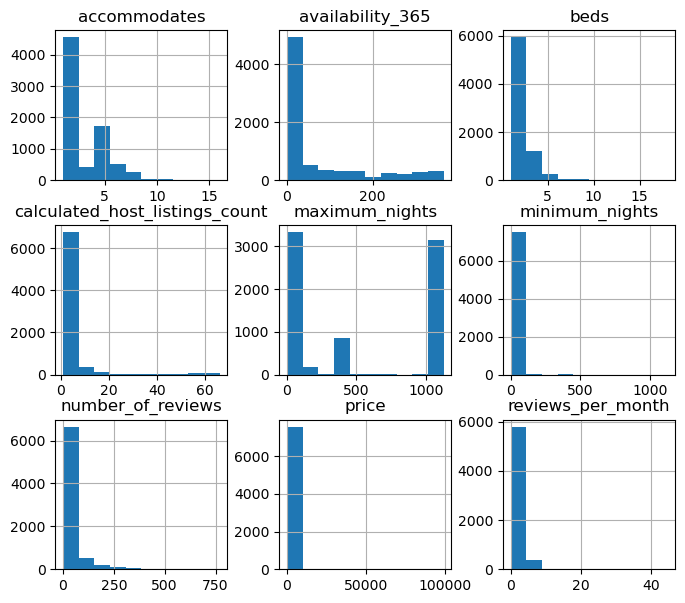

In [57]:
# histogram plots on input data

# bathrooms, calendar_updated, license, neighbourhood_group_cleansed removed because most are empty
# redundancy: availability_30, availability_60, availability_90, maximum_maximum_nights, maximum_minimum_nights, maximum_nights_avg_ntm, minimum_maximum_nights, minimum_minimum_nights, minimum_nights_avg_ntm, bedrooms
# redundancy: calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, host_listings_count, host_total_listings_count, number_of_reviews_l30d, number_of_reviews_ltm
# all 7 target features
hist_df = listings.copy()
exclude = ['id', 'scrape_id','host_id', 'listing_id', 'latitude', 'longitude', 'bathrooms', 'calendar_updated', 'license', 'neighbourhood_group_cleansed',
          'availability_30', 'availability_60', 'availability_90', 'maximum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights_avg_ntm',
          'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_total_listings_count', 'number_of_reviews_l30d', 'number_of_reviews_ltm',
          'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value', 'bedrooms']
hist_df.loc[:, hist_df.columns.difference(exclude)].hist(figsize=(8,7)) 

# listings.hist(figsize=(20,15))

# end of cleaning listings.csv. Rest of the notebook is trial and error

In [5]:
listings = pd.read_csv('almost_cleaned.csv')